*Pick up combined fMRI data for three subjects from gdrive*

In [1]:
# connect gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Paths
fMRI_BOLD_data_dir = "/content/drive/MyDrive/UofSC/AIISC/Data-fMRI/NL_Deep_fMRI/"

In [5]:
import os
import numpy as np
import pandas as pd


SUB_IDs = ["UTS01","UTS03","UTS07"]


fMRI_data = np.load(os.path.join(fMRI_BOLD_data_dir, f"{SUB_IDs[0]}_combined.npy"))




In [6]:
fMRI_data.shape

(8974, 423)

In [7]:
def compute_fc_matrix(roi_time_series: np.ndarray) -> np.ndarray:
    """
    roi_time_series: numpy array of shape (TRs, ROIs)
    returns: FC matrix (ROIs x ROIs) using Pearson correlation
    """

    # Ensure correct shape (ROIs x Time)
    X = roi_time_series.T   # (423, 8974)

    # Z-score along time dimension
    X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

    # Compute correlation matrix = (423 x 423)
    fc_matrix = np.dot(X, X.T) / X.shape[1]

    # Clip numerical floating error beyond [-1, 1]
    fc_matrix = np.clip(fc_matrix, -1.0, 1.0)

    return fc_matrix


def threshold_and_binarize(fc_matrix: np.ndarray, threshold: float = 0.25):
    """
    Apply magnitude threshold and build adjacency matrix
    """

    # Remove diagonal (self-loops)
    np.fill_diagonal(fc_matrix, 0.0)

    # Threshold (absolute value)
    fc_thresh = np.where(np.abs(fc_matrix) >= threshold, fc_matrix, 0.0)

    # Binarize adjacency matrix
    adjacency = (fc_thresh != 0).astype(int)

    return fc_thresh, adjacency


In [8]:
# Compute FC
fc_matrix = compute_fc_matrix(fMRI_data)
print("FC matrix shape:", fc_matrix.shape)

# Threshold & adjacency
threshold = 0.25
fc_filtered, adjacency = threshold_and_binarize(fc_matrix, threshold)

print("Filtered FC shape:", fc_filtered.shape)
print("Adjacency shape:", adjacency.shape)
print("Number of edges:", adjacency.sum())

FC matrix shape: (423, 423)
Filtered FC shape: (423, 423)
Adjacency shape: (423, 423)
Number of edges: 138752


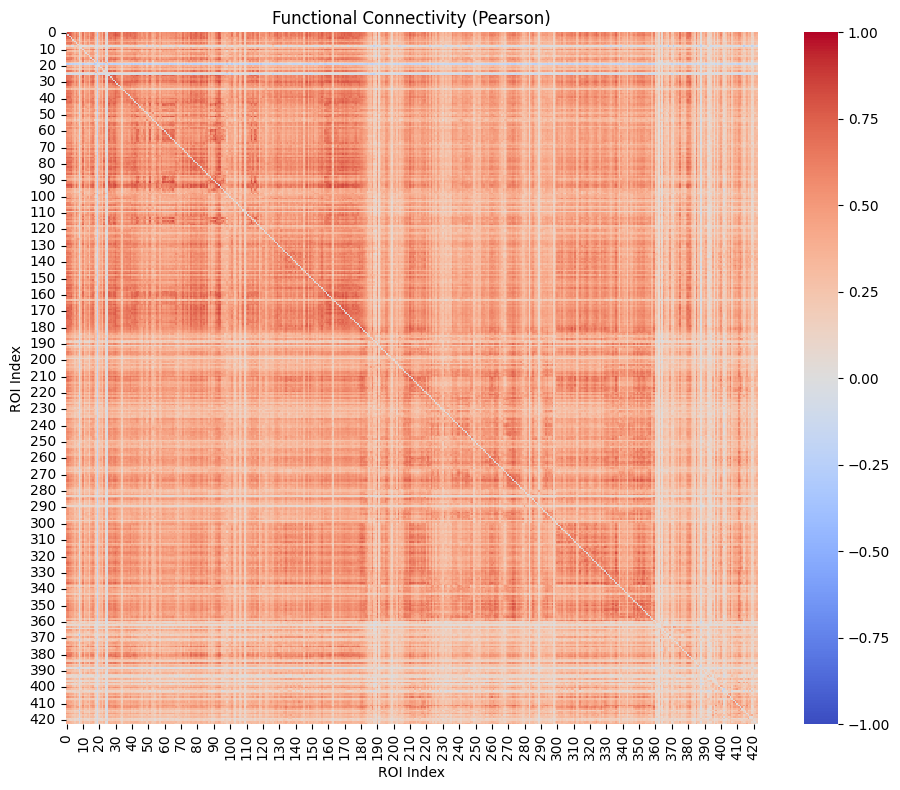

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_fc_heatmap(fc_matrix, title="Functional Connectivity (Pearson)"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(fc_matrix, cmap="coolwarm", vmin=-1, vmax=1, square=True)
    plt.title(title)
    plt.xlabel("ROI Index")
    plt.ylabel("ROI Index")
    plt.tight_layout()
    plt.show()

plot_fc_heatmap(fc_matrix)

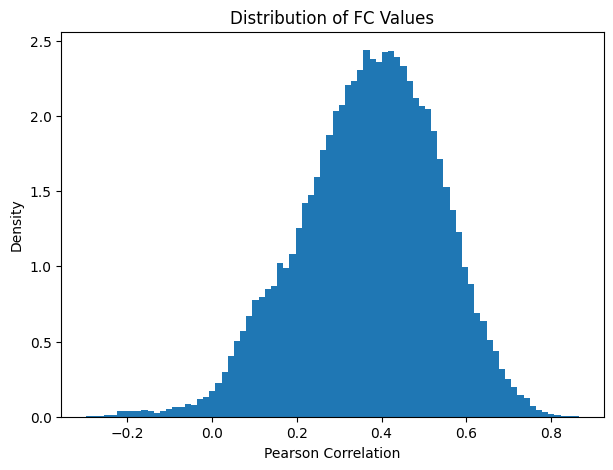

In [10]:
def plot_fc_histogram(fc_matrix):
    # Exclude diagonal values
    vals = fc_matrix[np.triu_indices_from(fc_matrix, k=1)]

    plt.figure(figsize=(7,5))
    plt.hist(vals, bins=80, density=True)
    plt.title("Distribution of FC Values")
    plt.xlabel("Pearson Correlation")
    plt.ylabel("Density")
    plt.show()

plot_fc_histogram(fc_matrix)

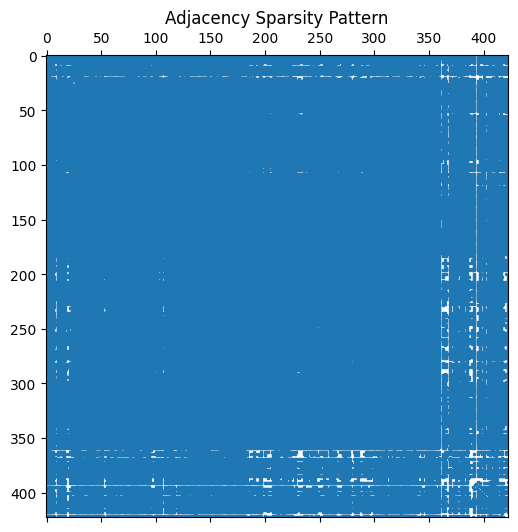

In [11]:
def plot_adjacency_sparsity(adj_matrix):
    plt.figure(figsize=(7,6))
    plt.spy(adj_matrix, markersize=2)
    plt.title("Adjacency Sparsity Pattern")
    plt.show()

plot_adjacency_sparsity(adjacency)

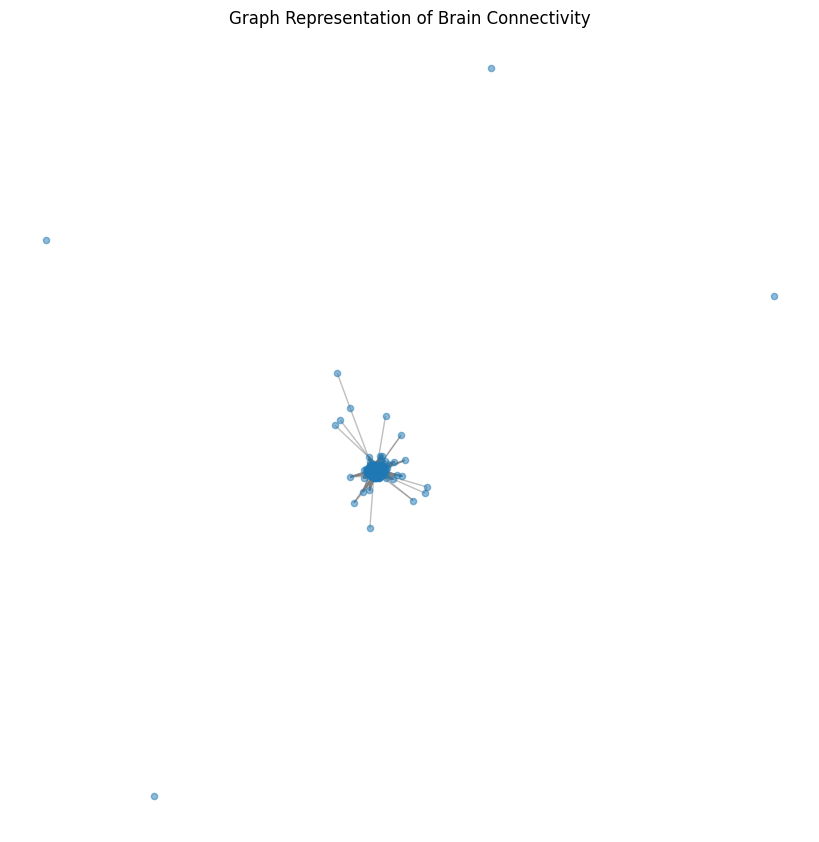

In [12]:
import networkx as nx

def plot_brain_graph(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)

    # spring layout
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_size=20, edge_color="gray", alpha=0.5)
    plt.title("Graph Representation of Brain Connectivity")
    plt.show()

plot_brain_graph(adjacency)